README

- Python version used for this file: 3.12.7
- Execute all cells in sequential order
- Required libraries: pandas, numpy, sklearn, seaborn, matplotlib
- Estimated time for running all cells (tested on windows): 1 minute 45 seconds



## 1. Supervised model training


In [1]:
import pandas as pd
import numpy as np

# keys for class labels
SCAM = 1
NON_MALICIOUS = 0

EPILSON = 1         # laplace smoothing parameter
FMT_OUTPUT = 60     # for model analysis paragraph formatting
TOP_NUM = 10        # the number of instances to be displayed


def vectorized_sentence(sentence, vocabulary):
    """
    Input: string `sentence`, a list of words `vocabulary`

    Convert a string into its vector form with each integer representing
    the word count in the string.

    Return: a list of size V where V is the number of words in `vocabulary`
    """

    words = sentence.split()
    return [words.count(word) for word in vocabulary]


def get_vocabulary_count(df):
    """
    Input: dataframe `df` containing message data

    Get a list of all unique words in the preprocessed text. And
    produce a matrix form representation of all instances' word count.

    Return: a list of words, a sparse matrix for word count
    """

    attr_text = df["textPreprocessed"].astype(str)

    # store all words that appeared in the training set's preprocessed text
    vocabulary_set = set()
    for sentence in attr_text:
        for word in sentence.split():
            vocabulary_set.add(word)
    vocabulary = list(vocabulary_set)

    # produce matrix representation of word count for all instances
    count = []
    for sentence in attr_text:
        count.append(vectorized_sentence(sentence, vocabulary))

    return vocabulary, count


def calc_prior(df):
    """
    Input: dataframe `df` containing message data

    Calculate the prior probability for each class label.

    Return: a dictionary containing the prior probability for each class
    """

    labels = df['class']

    # count the number of non-malicious and scam messages
    prior_prob = {}
    n = len(labels)
    unique_labels, counts = np.unique(labels, return_counts=True)

    # calculate the prior probability for scam & non-malicious messages
    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = counts[i] / n

    return prior_prob


def calc_likelihood(df, vocabulary, count):
    """
    Input: dataframe `df` containing message data, a list of words `vocabulary`,
    a matrix `count` representing all instances' word count

    Calculate the likelihood of word i appearing in class c. Laplace smoothing
    is applied to address the issue of having certain words missing in each class.

    Return: a dictionary containing the likelihood of word i appearing in class c
    """

    labels = df['class']
    unique_labels = np.unique(labels)

    # initialise container for likelihood of each word and total word count
    likelihood = {}
    total = {}
    for label in unique_labels:
        likelihood[label] = {}
        total[label] = 0

    for i in range(len(count)):
        # compute the total number of words in each class
        label = labels.loc[i]
        total[label] += sum(count[i])

        # compute individual words' frequency in each class
        for j in range(len(vocabulary)):
            word = vocabulary[j]
            if word not in likelihood[label]:
                likelihood[label][word] = 0
            likelihood[label][word] += count[i][j]

    # convert from frequency to empirical probability (laplace smoothing is used)
    for label in unique_labels:
        for word in vocabulary:
            likelihood[label][word] = \
                (likelihood[label][word] + EPILSON) / (total[label] + len(vocabulary) * EPILSON)
            
    return likelihood


def train_NB(df):
    """
    Input: dataframe `df` containing message data, with fields 'textPreprocessed', 'class'

    Train a Naive Bayes model based on the given training data.

    Return: a list of words appeared in the training data's preprocessed text,
    a dictionary containing the prior probability of each class,
    a dictionary containing the likelihood of word i appearing in class c
    """

    # first get all words and matrix representation of all instances
    vocabulary, count = get_vocabulary_count(df)

    # calculate the prior probability of each class
    prior_prob = calc_prior(df)

    # calculate the likelihood of word i appearing in class c
    likelihood = calc_likelihood(df, vocabulary, count)

    return vocabulary, prior_prob, likelihood


def show_prior_prob_table(prior_prob):
    """
    Input: a dictionary `prior_prob`

    Print the prior probability of each class.
    """

    print("Prior proability table")
    for label, value in prior_prob.items():
        if label == NON_MALICIOUS:
            label_text = "non-malicious"
        elif label == SCAM:
            label_text = "scam"
        print(f"{label_text}: {value}")
    print("=" * FMT_OUTPUT)


def show_most_probable_word(likelihood):
    """
    Input: a dicionary `likelihood`

    Sort the words based on their likelihood to appear in each class.
    Print the words that are most likely to appear in each class.
    """

    for label in likelihood.keys():
        # print heading
        if label == NON_MALICIOUS:
            label_text = "non-malicious"
        elif label == SCAM:
            label_text = "scam"
        print(f"Top {TOP_NUM} most probable words in class {label_text}")

        # sort all the words based on likelihood value
        top_prob_words = sorted(likelihood[label].items(), key=lambda x: x[1], reverse=True)

        # print words that are mostly likely to appear
        for i in range(TOP_NUM):
            print(f"{i+1}: {top_prob_words[i]}")
        print("=" * FMT_OUTPUT)


def show_most_predictive_words(likelihood):
    """
    Input: a dictionary `likelihood`
    
    Compute the most predictive words for each class by comparing their probability ratio.
    A higher probability ratio P(c1,i) / P(c2,i) indicates that word i is more likely to
    appear in class c1. Print the top most strongly predictive words for each class.
    """

    # calculate probability ratio for every word
    prob_ratio_NM = {}
    prob_ratio_SC = {}
    for word in likelihood[SCAM].keys():
        # Pr(word in non-malicious | non-malicious) / Pr(word in scam | scam)
        prob_ratio_NM[word] = likelihood[NON_MALICIOUS][word] / likelihood[SCAM][word]
        # Pr(word in scam | scam) / Pr(word in non-malicious | non-malicious)
        prob_ratio_SC[word] = likelihood[SCAM][word] / likelihood[NON_MALICIOUS][word]
    PR_NM_sorted = sorted(prob_ratio_NM.items(), key=lambda x: x[1], reverse=True)
    PR_SC_sorted = sorted(prob_ratio_SC.items(), key=lambda x: x[1], reverse=True)

    for label in likelihood.keys():
        # print heading
        if label == NON_MALICIOUS:
            label_text = "non-malicious"
            top_words = PR_NM_sorted
        elif label == SCAM:
            label_text = "scam"
            top_words = PR_SC_sorted
        print(f"Top {TOP_NUM} most strongly predictive words for class {label_text}")

        # print words that are most strongly predictive of each class
        for i in range(TOP_NUM):
            print(f"{i+1}: {top_words[i]}")
        print("=" * FMT_OUTPUT)


def print_model_NB_summary(model_NB):
    """
    Input: a Naive Bayes model `model_NB`

    Provide a summary of the Naive Bayes model.
    """

    _, prior_prob, likelihood = model_NB

    # print prior probability for each class
    show_prior_prob_table(prior_prob)

    # print words with highest likelihood to appear in each class
    show_most_probable_word(likelihood)

    # print words that are most strongly predictive of each class
    show_most_predictive_words(likelihood)


train_df = pd.read_csv("sms_supervised_train.csv")

# train the Naive Bayes model
model_NB = train_NB(train_df)

# get summary of the model
print_model_NB_summary(model_NB)



Prior proability table
non-malicious: 0.8
scam: 0.2
Top 10 most probable words in class non-malicious
1: ('.', 0.07930378329975375)
2: (',', 0.026024177300201477)
3: ('?', 0.025576449518692635)
4: ('u', 0.0189164987687486)
5: ('...', 0.018748600850682785)
6: ('!', 0.017181553615401836)
7: ('..', 0.014942914707857623)
8: (';', 0.013152003581822252)
9: ('&', 0.013096037609133646)
10: ('go', 0.01113722856503246)
Top 10 most probable words in class scam
1: ('.', 0.05652173913043478)
2: ('!', 0.02434782608695652)
3: (',', 0.023478260869565216)
4: ('call', 0.020543478260869566)
5: ('£', 0.01391304347826087)
6: ('free', 0.010543478260869566)
7: ('/', 0.009130434782608696)
8: ('2', 0.008804347826086956)
9: ('&', 0.008695652173913044)
10: ('?', 0.008478260869565218)
Top 10 most strongly predictive words for class non-malicious
1: (';', 60.49921647638236)
2: ('...', 57.4957092754272)
3: ('gt', 54.06312961719275)
4: ('lt', 53.548242668457576)
5: (':)', 47.88448623237072)
6: ('ü', 31.9229908215804

## 2. Supervised model evaluation

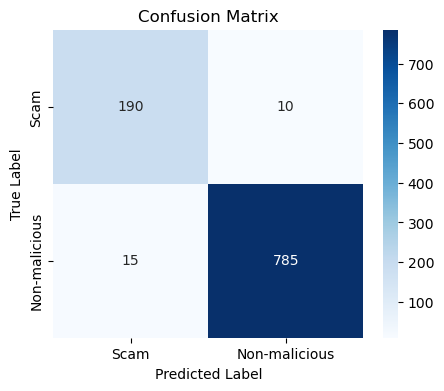

Total number of test cases: 1000
Accuracy: 0.975
Precision: 0.926829268292683
Recall: 0.95
F1 Score: 0.9382716049382716
Number of skipped instances: 0
Number of out of vocabulary instances: 142
1: ('. sleep enough trouble', {'trouble'})
2: ('? . u dude guy 2nite', {'2nite'})
3: ('. . 4 send : win easy just question hmv hmv hmv bonus special 500 pound vouchers answer 86688 info', {'hmv'})
4: ('? . , , hope ... tell ! * * love hey sexy loverboy remember thank sister law grin babe', {'law'})
5: ('. . . . . , great ok call / / - - per noida @ full plot available near book start onwards down', {'plot'})
6: ('up u hope good ! wake morning lol pie', {'pie'})
7: ('... ... da neva photo drivin nope leu', {'drivin'})
8: ('oh actually keep " " " " see shit weird realise', {'realise'})
9: ('up , guy alright hook', {'hook'})
10: ('? ? . up u , ! ! wk x babe d doin alright \x92 nearly sn', {'nearly'})
Top 10 confident instances for non-malicious
1: (9.134994451628908e+37, 'time : rs. transaction num

In [2]:
from math import factorial, exp, log
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# flag variables for whether an instance is out of vocabulary
NOT_OOV = 0
OOV = 1
SKIP = 2

BOUNDARY = 1        # search for confidence values that are close to the boundary
TOP_NUM = 10      # the number of instances to be displayed


def check_vocabulary(sentence, vocabulary):
    """
    Input: string `sentence`, a list of words `vocabulary`

    Check whether any words in the sentence are missing from the given list of words.

    Return: a flag variable indicating the status of the instance,
    a set indicating the words that are missing from vocabulary list
    """

    words = set(sentence.split())
    diff = words - set(vocabulary)

    # instances with no words in common
    if len(words) == len(diff):
        flag = SKIP
    # instances without out of vocabulary words
    elif len(diff) == 0:
        flag = NOT_OOV
    # instances with some out of vocabulary words
    else:
        flag = OOV

    return flag, diff


def calc_posterior(count, model_NB, log_probs):
    """
    Input: a vector `count`, Naive Bayes model `model_NB`, a log likelihood dictionary `log_probs`

    Calculate the posterior probability of the given instance being in each class.

    Return: a dictionary of posterior probabilities
    """

    vocabulary, prior_prob, likelihood = model_NB
    post_probs = {}
    
    # convert the likelihood to vector form for multinomial calculation
    # natural log is used to prevent underflow
    if not log_probs:
        for label in likelihood.keys():
            log_probs[label] = [log(likelihood[label][word]) for word in vocabulary]

    log_factorial_n = log(factorial(sum(count)))
    sum_log_factorial_count = sum([log(factorial(x)) for x in count])

    for label in log_probs.keys():
        # log of the pmf for multinomial distribution
        log_multinomial_prob = log_factorial_n - sum_log_factorial_count \
            + sum([count[i] * log_probs[label][i] for i in range(len(count))])
        post_probs[label] = prior_prob[label] * exp(log_multinomial_prob)

    return post_probs


def calc_confidence(post_probs):
    """
    Input: a dictionary `post_probs`

    Compute the confidence of the classification decision for the given posterior probabilities.

    Return: a floating point confidence value
    """

    # store the confidence value that is greater than 1
    if post_probs[NON_MALICIOUS] / post_probs[SCAM] > 1:
        confidence = post_probs[NON_MALICIOUS] / post_probs[SCAM]
    else:
        confidence = post_probs[SCAM] / post_probs[NON_MALICIOUS]

    return confidence
    

def predict_message(sentence, model_NB, log_probs):
    """
    Input: string `sentence`, Naive Bayes model `model_NB`, a log likelihood dictionary `log_probs`

    Check whether an instance should be skipped or not. And make a prediction
    about the probability of the given instance being classified in each class.

    Return: a flag variable indicating the status of the instance,
    a set indicating the words that are missing from vocabulary list,
    a dictionary of posterior probabilities
    """

    vocabulary = model_NB[0]

    # first check whether there are missing words
    flag, diff = check_vocabulary(sentence, vocabulary)
    post_probs = None

    # proceed to compute posterior probability if not all words are missing from vocabulary
    if flag != SKIP:
        count = vectorized_sentence(sentence, vocabulary)
        post_probs = calc_posterior(count, model_NB, log_probs)
        
    return flag, diff, post_probs


def predict_NB(df, model_NB):
    """
    Input: test data dataframe `df`, Naive Bayes model `model_NB`

    Make a prediction about the class label of all instances in the given test dataset.

    Return: a list of predicted labels for each instance
    a list of confidence values for each instance
    a list of instances that encountered the issue of out of vocabulary
    a list of instances that were skipped
    """

    test_features = df["textPreprocessed"].astype(str)

    skipped_instances = []
    out_of_vocabulary = []
    confidence_list = []
    argmax_labels = []
    log_probs = {}

    for instance in test_features:
        # get given instance's posterior probability
        flag, diff, post_probs = predict_message(instance, model_NB, log_probs)
        
        # skip messages with no words in vocabulary
        if flag == SKIP:
            skipped_instances.append(instance)
            argmax_labels.append(None)
            confidence_list.append((instance, None))
            out_of_vocabulary.append((instance, set(instance.split())))
            continue
        # record instances that are out of vocabulary
        elif flag == OOV:
            out_of_vocabulary.append((instance, diff))
        
        # compute the predicted label and the confidence of the prediction
        argmax = max(post_probs.items(), key=lambda x: x[1])
        confidence = calc_confidence(post_probs)
        confidence_list.append((instance, (argmax[0], confidence)))
        argmax_labels.append(argmax[0])

    return argmax_labels, confidence_list, out_of_vocabulary, skipped_instances


def show_out_of_vocabulary(out_of_vocabulary, skipped_instances):
    """
    Input: a list of instances `out_of_vocabulary`, a list of instances `skipped_instances`

    Display the test result regarding instances that are out of vocabulary or skipped during testing.
    """

    # display some skipped instances
    n1 = len(skipped_instances)
    print(f"Number of skipped instances: {n1}")
    for i in range(min(n1, TOP_NUM)):
        print(f"{i+1}: {skipped_instances[i]}")
    print("=" * FMT_OUTPUT)

    # display some instances that encountered out of vocabulary
    n2 = len(out_of_vocabulary)
    print(f"Number of out of vocabulary instances: {n2}")
    for i in range(min(n2, TOP_NUM)):
        print(f"{i+1}: {out_of_vocabulary[i]}")
    print("=" * FMT_OUTPUT)


def show_metrics(df, argmax_labels):
    """
    Input: test data dataframe `df`, list of predictions `argmax_labels`

    Evaluate the model by printing relevant metrics including confusion matrix, accuracy,
    precision, recall, f1 score...
    """

    truth_labels = df['class']

    # Remove None values (Keep only valid indices)
    filtered = [(t, p) for t, p in zip(truth_labels, argmax_labels) if t is not None and p is not None]
    truth_clean, prediction_clean = zip(*filtered)

    # compute confusion matrix
    # note that TP is displayed at the top left cell
    cm = confusion_matrix(np.array(truth_clean), np.array(prediction_clean), labels=[1,0])

    # compute classification metrics
    accuracy = accuracy_score(truth_clean, prediction_clean)
    precision = precision_score(truth_clean, prediction_clean)
    recall = recall_score(truth_clean, prediction_clean)
    f1 = f1_score(truth_clean, prediction_clean)

    # display results
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Scam", "Non-malicious"],
                yticklabels=["Scam", "Non-malicious"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    print("=" * FMT_OUTPUT)

    # display other metrics
    print(f"Total number of test cases: {len(truth_labels)}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("=" * FMT_OUTPUT)


def calc_top_confidence(confidence_list, label):
    """
    Input: a list of instances with confidence value `confidence_list`, a class label `label`

    Display instances with top confidence based on the given class label.
    """

    # sort the instances with the given predicted label
    confidence_arr = [(instance, conf[1]) for instance, conf in confidence_list
                      if conf != None and conf[0] == label]
    confidence_arr.sort(key=lambda x: x[1], reverse=True)

    if label == NON_MALICIOUS:
        label_text = "non-malicious"
    elif label == SCAM:
        label_text = "scam"

    # display instances with top confidence
    print(f"Top {TOP_NUM} confident instances for {label_text}")
    for i in range(TOP_NUM):
        print(f"{i+1}: ({confidence_arr[i][1]}, '{confidence_arr[i][0]}')")
    print("=" * FMT_OUTPUT)


def calc_boundary_confidence(confidence_list):
    """
    Input: a list of instances with confidence value `confidence_list`

    Rank instances based on how close their confidence values are to a given boundary value.
    """

    # sort based on the given boundary value
    confidence_list_cleaned = [instance for instance in confidence_list if instance[1] != None]
    sorted_confidence = sorted(confidence_list_cleaned, key=lambda x: abs(x[1][1] - BOUNDARY))

    # display instances that have confidence value close to the boundary
    print(f"Top {TOP_NUM} instances with boundary near {BOUNDARY}")
    print("Note: The displayed label is the predicted label")
    for i in range(TOP_NUM):
        instance, confidence = sorted_confidence[i]
        if confidence[0] == SCAM:
            label_text = "Scam"
        elif confidence[0] == NON_MALICIOUS:
            label_text = "Non-malicious"
        print(f"{i+1}: {label_text}, ({confidence[1]}, '{instance}')")
    print("=" * FMT_OUTPUT)


def show_confidence(confidence_list):
    """
    Input: a list of instances with confidence value `confidence_list`

    Provide a summary of the confidence values for the test cases' predictions
    """

    # display top confidence values for non-malicious messages
    calc_top_confidence(confidence_list, NON_MALICIOUS)

    # display top confidence values for scam messages
    calc_top_confidence(confidence_list, SCAM)
    
    # display top confidence values that are close to a certain boundary
    calc_boundary_confidence(confidence_list)


def analyse_results(df, test_results):
    """
    Input: test data dataframe `df`, results produced by Naive Bayes model `test_results`

    Provide an evaluation of the test results produced by the Naive Bayes model.
    """

    argmax_labels, confidence_list, out_of_vocabulary, skipped_instances = test_results

    # display all relevant metrics regarding the test result
    show_metrics(df, argmax_labels)

    # display all instances that were out of vocabulary or completely skipped
    show_out_of_vocabulary(out_of_vocabulary, skipped_instances)

    # provide a summary of the confidence values for the model's predictions
    show_confidence(confidence_list)


test_df = pd.read_csv("sms_test.csv")

# get model prediction result for the Naive Bayes model
test_results = predict_NB(test_df, model_NB)

# get summary of the model's predictions
analyse_results(test_df, test_results)




## 3. Extending the model with semi-supervised training

In [3]:
### This section is for comparing the uncertainty value between correctly and incorrectly predicted instances.

def confidence_to_uncertainty(confidence_list):
    """
    Input: a list of confidence values for each instance `confidence_list`.

    Convert confidence values into uncertainty scores.

    Return: the prediction uncertainty score for all given instances
    """

    # transformation with natural log to reduce effect of outliers.
    log_scaled_confidence = []

    for _, conf in confidence_list:
        if conf != None:
            log_scaled_confidence.append(log(conf[1]))
        else:
            log_scaled_confidence.append(0)     # assume 0 log confidence for skipped instances
    
    # min-max normalization and then invert to get the uncertainty score
    max_log_confidence = max(log_scaled_confidence)
    min_log_confidence = min(log_scaled_confidence)
    uncertainty_scores = [(1 - (x - min_log_confidence) / (max_log_confidence - min_log_confidence)) for x in log_scaled_confidence]

    return uncertainty_scores


def compare_average(df, test_results, scores):
    """
    Input: test dataset `df`, prediction results `test_results`, and some scores corresponding to each instance `scores` 

    Compare some scores for the correctly and incorrectly classified instances.

    Return: the average score for correctly, and incorrectly classified instances
    """

    predict_labels = test_results[0]
    truth_labels = df['class']
    correct_labels = {'score': 0, 'n': 0}
    incorrect_labels = {'score': 0, 'n': 0}

    # sum up the scores
    for i in range(len(truth_labels)):
        if predict_labels[i] == truth_labels[i]:
            correct_labels['n'] += 1
            correct_labels['score'] += scores[i]
        else:
            incorrect_labels['n'] += 1
            incorrect_labels['score'] += scores[i]

    # calculate the average score
    results = {
        'correct': correct_labels['score'] / correct_labels['n'],
        'incorrect': incorrect_labels['score'] / incorrect_labels['n']
    }

    return results

argmax_labels, confidence_list, out_of_vocabulary, skipped_instances = test_results

# get uncertainty scores
uncertainty_scores = confidence_to_uncertainty(confidence_list)

# average uncertainty score for correctly and incorrectly classified instances in part 2
print(compare_average(test_df, test_results, uncertainty_scores))
print("=" * FMT_OUTPUT)


{'correct': 0.8530105053751047, 'incorrect': 0.9449419501283002}


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

FSCORE_WEIGHT = 2       # beta for recall

def normalize_oov(df, out_of_vocabulary):
    """
    Input: test dataset `df`, instances that encountered OOV `out_of_vocabulary`

    Normalize the OOV scores for each instance.

    Return: the normalized OOV scores for all given instances.
    """

    attr_text = df["textPreprocessed"].astype(str)
    oov_scores = []

    # apply log transformation to reduce the effect of outliers
    oov_dictionary = {instance: log(len(oov)+1) for instance, oov in out_of_vocabulary}

    # create a list of oov scores
    for instance in attr_text:
        if instance in oov_dictionary.keys():
            oov_scores.append(oov_dictionary[instance])
        else:
            oov_scores.append(0)
    
    # apply min-max normalization to the log oov scores.
    max_oov = max(oov_scores)
    min_oov = min(oov_scores)
    normalized_oov_scores = [(x - min_oov) / (max_oov - min_oov) for x in oov_scores]

    return normalized_oov_scores


def calc_importance_index(explanatory_variables, alpha=0.5, gamma=1):
    """
    Input: The explanatory variables `explanatory_variables`, hyperparameters `alpha` and `gamma`

    Calculate the importance index for each instance based on oov scores and uncertainty scores.

    Return: a list of importance index for each instance
    """

    oov_scores, uncertainty_scores = explanatory_variables
    importance_index_list = []
    
    # apply the formula to calculate the importance index
    for i in range(len(oov_scores)):
        importance_index = (1 - alpha) * (oov_scores[i] ** gamma) + alpha * (uncertainty_scores[i] ** gamma)
        importance_index_list.append(importance_index)

    return importance_index_list


def hyperparameter_tuning(supervised_train_df, validate_size=0.2):
    """
    Input: the training dataset for supervised training `supervised_train_df`,
    and the size of validation set `validate_size`

    Perform hyperparameter tuning to find optimal alpha and gamma.

    Return: a list of alpha, gamma, along with their respective evaluation metric score.
    """

    # stratified sampling to produce training set, validation set
    train_df, validate_df = train_test_split(
        supervised_train_df, test_size=validate_size, stratify=supervised_train_df['class'], random_state=144
    )

    # stratified sampling to produce training set, "unlabelled" set
    unlabelled_size = len(validate_df) / len(train_df)
    train_df, unlabelled_df = train_test_split(
        train_df, test_size=unlabelled_size, stratify=train_df['class'], random_state=9054
    )

    # the number of instance to select from "unlabelled" set
    num_select = int(len(unlabelled_df) * 0.2)

    # reset the index column of the dataframes
    train_df = train_df.reset_index().reset_index()
    validate_df = validate_df.reset_index().reset_index()
    truth_labels = validate_df['class']

    # train a guide model that will be used to analyze the unlabelled dataset
    model_NB_guide = train_NB(train_df)

    # predict all unlabelled instances based on our guide model
    test_results = predict_NB(unlabelled_df, model_NB_guide)
    _, confidence_list, out_of_vocabulary, _ = test_results

    # compute the out-of-vocabulary scores and uncertainty scores for all instances
    oov_scores = normalize_oov(unlabelled_df, out_of_vocabulary)
    uncertainty_scores = confidence_to_uncertainty(confidence_list)
    explanatory_variables = (oov_scores, uncertainty_scores)
    
    # a list of potential values for parameter alpha and beta
    alpha_candidates = [0.1, 0.3, 0.5, 0.7, 0.9]
    gamma_candidates = [1, 1.5, 2, 2.5, 3]
    f2_scores = []

    # find the f2 score for all candidates
    for gamma in gamma_candidates:
        for alpha in alpha_candidates:

            # compute importance index and select instances with highest importance
            importance_index_list = calc_importance_index(explanatory_variables, alpha, gamma)
            top_instances_indices = pd.Series(importance_index_list).nlargest(num_select).index

            # combine the selected instances with the training set
            selected_df = unlabelled_df.iloc[top_instances_indices]
            new_train_df = pd.concat([train_df, selected_df], ignore_index=True)

            # retrain the model and test on the validation set
            model_NB_test = train_NB(new_train_df)
            test_results = predict_NB(validate_df, model_NB_test)
            prediction_labels = test_results[0]

            # compute the f2 score for the given set of alpha, gamma values
            filtered_true = [yt for yt, yp in zip(truth_labels, prediction_labels) if yp is not None]
            filtered_pred = [yp for yp in prediction_labels if yp is not None]
            f2_score = fbeta_score(filtered_true, filtered_pred, beta=FSCORE_WEIGHT)
            f2_scores.append(((alpha, gamma), f2_score))

    return f2_scores


unlabelled_df = pd.read_csv("sms_unlabelled.csv")

# perform hyperparameter tuning
parameter_rating = hyperparameter_tuning(train_df)

# list the f2 score for all sets of parameters
print("Hyperparameter F2-score table:")
for parameters, rating in parameter_rating:
    print(f"F2-score for {parameters}: {round(rating, 4)}")
print("=" * FMT_OUTPUT)


Hyperparameter F2-score table:
F2-score for (0.1, 1): 0.9476
F2-score for (0.3, 1): 0.9453
F2-score for (0.5, 1): 0.9453
F2-score for (0.7, 1): 0.9453
F2-score for (0.9, 1): 0.9476
F2-score for (0.1, 1.5): 0.9476
F2-score for (0.3, 1.5): 0.9453
F2-score for (0.5, 1.5): 0.9453
F2-score for (0.7, 1.5): 0.9453
F2-score for (0.9, 1.5): 0.9577
F2-score for (0.1, 2): 0.9476
F2-score for (0.3, 2): 0.9453
F2-score for (0.5, 2): 0.9453
F2-score for (0.7, 2): 0.9553
F2-score for (0.9, 2): 0.9577
F2-score for (0.1, 2.5): 0.9476
F2-score for (0.3, 2.5): 0.9453
F2-score for (0.5, 2.5): 0.9553
F2-score for (0.7, 2.5): 0.9577
F2-score for (0.9, 2.5): 0.9577
F2-score for (0.1, 3): 0.9476
F2-score for (0.3, 3): 0.9553
F2-score for (0.5, 3): 0.9553
F2-score for (0.7, 3): 0.9577
F2-score for (0.9, 3): 0.9577


In [5]:
NUM_SELECTION = 200     # number of instances to be selected from unlabelled dataset

def active_learning(train_df, unlabelled_df, alpha, gamma):
    """
    Input: a training dataset `train_df`, an unlabelled dataset `unlabelled_df`, parameter `alpha` and `beta`

    Use the active learning approach to train a semi-supervised Naive Bayes model.

    Return: a semi-supervised Naive Bayes model
    """

    # train a guide model that will be used to analyze the unlabelled dataset
    model_NB_guide = train_NB(train_df)

    # predict all unlabelled instances based on our guide model
    test_results = predict_NB(unlabelled_df, model_NB_guide)
    _, confidence_list, out_of_vocabulary, _ = test_results

    # compute the out-of-vocabulary scores and uncertainty scores for all instances
    oov_scores = normalize_oov(unlabelled_df, out_of_vocabulary)
    uncertainty_scores = confidence_to_uncertainty(confidence_list)
    explanatory_variables = (oov_scores, uncertainty_scores)
    
    # compute importance index and select the specified number of instances
    importance_index_list = calc_importance_index(explanatory_variables, alpha, gamma)
    top_instances_indices = pd.Series(importance_index_list).nlargest(NUM_SELECTION).index

    # retrain the model using the combined dataset
    selected_df = unlabelled_df.iloc[top_instances_indices]
    new_train_df = pd.concat([train_df, selected_df], ignore_index=True)
    model_NB_AL = train_NB(new_train_df)

    return model_NB_AL


alpha = 0.9
gamma = 3

# train a Naive Bayes model using the active learning approach with the tuned hyperparameters
model_NB_AL = active_learning(train_df, unlabelled_df, alpha, gamma)


## 4. Supervised model evaluation

Prior proability table
non-malicious: 0.8022727272727272
scam: 0.19772727272727272
Top 10 most probable words in class non-malicious
1: ('.', 0.08180452741122198)
2: (',', 0.026499302649930265)
3: ('?', 0.0255873833279691)
4: ('u', 0.018452955691449415)
5: ('...', 0.017970174873940564)
6: ('!', 0.017541036369488252)
7: ('..', 0.014376139899152452)
8: (';', 0.012605943568286664)
9: ('&', 0.012552301255230125)
10: ('go', 0.01067482029825126)
Top 10 most probable words in class scam
1: ('.', 0.05807188863494702)
2: ('!', 0.024620818616247663)
3: (',', 0.02410139206316227)
4: ('call', 0.02077706212341575)
5: ('£', 0.013401205069603158)
6: ('free', 0.010596301682942032)
7: ('&', 0.00914190733430293)
8: ('/', 0.00914190733430293)
9: ('?', 0.00914190733430293)
10: ('2', 0.008726366091834614)
Top 10 most strongly predictive words for class non-malicious
1: ('gt', 54.21789507563567)
2: ('lt', 53.701534170153415)
3: (':)', 49.054286020813215)
4: ('...', 34.59618066731038)
5: ('ü', 32.01437613989

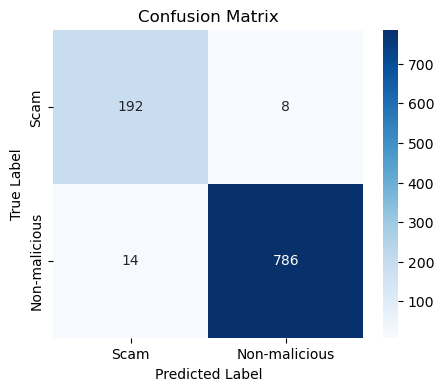

Total number of test cases: 1000
Accuracy: 0.978
Precision: 0.9320388349514563
Recall: 0.96
F1 Score: 0.9458128078817734
Number of skipped instances: 0
Number of out of vocabulary instances: 123
1: ('. sleep enough trouble', {'trouble'})
2: ('? . u dude guy 2nite', {'2nite'})
3: ('. . 4 send : win easy just question hmv hmv hmv bonus special 500 pound vouchers answer 86688 info', {'hmv'})
4: ('? . , , hope ... tell ! * * love hey sexy loverboy remember thank sister law grin babe', {'law'})
5: ('. . . . . , great ok call / / - - per noida @ full plot available near book start onwards down', {'plot'})
6: ('... ... da neva photo drivin nope leu', {'drivin'})
7: ('up , guy alright hook', {'hook'})
8: ('? ? . up u , ! ! wk x babe d doin alright \x92 nearly sn', {'nearly'})
9: ('? home ... time ü ü dad dat login fetch', {'fetch'})
10: ('lor lor late already ... ... ... r e eat cos v n laugh dunno reach gal inside', {'inside'})
Top 10 confident instances for non-malicious
1: (1.01537973397548

In [6]:
TOP_NUM = 10        # the number of instances to be displayed

# provide model summary
print_model_NB_summary(model_NB_AL)

# get model prediction result for the Naive Bayes model
test_results_AL = predict_NB(test_df, model_NB_AL)

# get summary of the model's predictions
analyse_results(test_df, test_results_AL)


Supervised model:
('. . . . . , great ok call / / - - per noida @ full plot available near book start onwards down', (0, 1.3499823907249169))
Semisupervised model:
('. . . . . , great ok call / / - - per noida @ full plot available near book start onwards down', (1, 2.0606396736391948))
Truth: 1
Supervised model:
('? 1 2 u u hope time / £ & 2nite luv c alone want to chat xx cum calls', (0, 2.520973796729048))
Semisupervised model:
('? 1 2 u u hope time / £ & 2nite luv c alone want to chat xx cum calls', (1, 2.849065020617968))
Truth: 1
Supervised model:
('? ur * just alrite sam', (1, 1.07975667795837))
Semisupervised model:
('? ur * just alrite sam', (0, 1.1998465216384788))
Truth: 0
{1.5: 13, 2: 17, 2.5: 22, 3: 25, 3.5: 28, 4: 29, 4.5: 32, 5: 33}
{1.5: 7, 2: 11, 2.5: 19, 3: 23, 3.5: 26, 4: 32, 4.5: 33, 5: 35}


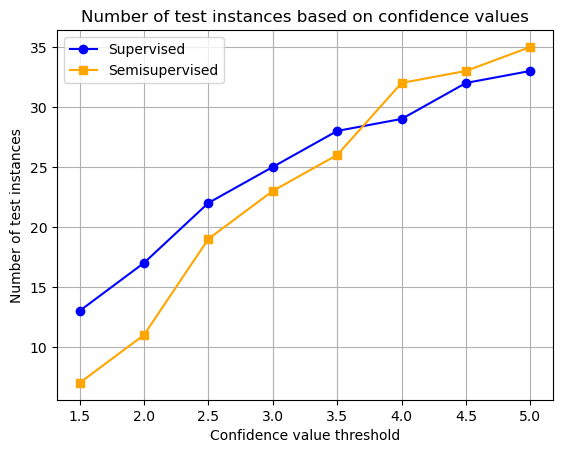

In [7]:
import matplotlib.pyplot as plt

def confidence_values_threshold(confidence_list, thresholds):
    """
    Input: a list of confidence values `confidence_list` and a list of value thresholds `thresholds`

    Count the number test instances below each threshold value.

    Return: a dictionary of threshold value with instance count
    """

    confidence_counter = {}
    for threshold in thresholds:
        # initialize counter
        confidence_counter[threshold] = 0

        # count all items below the threshold
        for item in confidence_list:
            if item[1][1] < threshold:
                confidence_counter[threshold] += 1
    
    return confidence_counter


def graph_confidence(confidence_list_supervised, confidence_list_semisupervised, thresholds):
    """
    Input: a list of confidence values for the supervised model `confidence_list_supervised`
    a list of confidence values for the semi-supervised model `confidence_list_semisupervised`
    a list of thresholds for the plot `thresholds`

    Graph the the list of confidence values based on the thresholds.
    With x axis being the threshold, y axis being the number of instances below the threshold.
    """

    # calculate instances count below each threshold
    confidence_count_supervised = confidence_values_threshold(confidence_list_supervised, thresholds)
    confidence_count_semisupervised = confidence_values_threshold(confidence_list_semisupervised, thresholds)

    # show the instances count
    print(confidence_count_supervised)
    print(confidence_count_semisupervised)
    print("=" * FMT_OUTPUT)

    # Sort by keys to ensure lines are connected in the right order
    x1, y1 = zip(*sorted(confidence_count_supervised.items()))
    x2, y2 = zip(*sorted(confidence_count_semisupervised.items()))

    # Plotting the number of test instances
    plt.plot(x1, y1, marker='o', label='Supervised', color='blue')
    plt.plot(x2, y2, marker='s', label='Semisupervised', color='orange')

    # graph titles and labels
    plt.xlabel('Confidence value threshold')
    plt.ylabel('Number of test instances')
    plt.title('Number of test instances based on confidence values')
    plt.legend()
    plt.grid(True)
    plt.show()


# break point for analyze confidence values
thresholds_low = [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# analyze the confidence in more details
confidence_supervised = test_results[1]
confidence_semisupervised = test_results_AL[1]

# truth labels for all test instances
truth_labels = test_df['class']

# extract instances that the two models predicted differently
for i in range(len(confidence_supervised)):
    conf_sup = confidence_supervised[i]
    conf_semisup = confidence_semisupervised[i]

    # show differences in confidence values and predictions
    if conf_sup[1][0] != conf_semisup[1][0]:
        print("Supervised model:")
        print(conf_sup)
        print("Semisupervised model:")
        print(conf_semisup)
        print(f"Truth: {truth_labels.iloc[i]}")
        print("=" * FMT_OUTPUT)

# graph the confidence values based on the thresholds
graph_confidence(confidence_supervised, confidence_semisupervised, thresholds_low)


